In [13]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
torch.set_printoptions(precision=6)

def func(list_x, triples, list_z, list_c):
    list_x = list_x.detach().requires_grad_()
    if list_x.shape != (len(list_x), 2):
        return float('inf'), None
    out = func_F(list_x, triples, list_z, list_c)
    out.backward()
    return out, list_x.grad

def func_f(x1, x2, x3):
    X = torch.stack([x2-x1, x3-x1])
    return torch.linalg.det(X)

def func_F(list_x, triples, list_z, list_c, lda = 0.01):
    term_1, term_2 = 0, 0
    for l in range(len(list_x)):
        x_l = list_x[l]
        z_l = list_z[l]
        term_1 += torch.square(torch.norm(x_l - z_l))
    term_1 = term_1 * (1/len(list_x))
    
    for q in range(len(triples)):
        x_i = list_x[triples[q][0]]
        x_j = list_x[triples[q][1]]
        x_k = list_x[triples[q][2]]
        term_2 += torch.square(torch.log(func_f(x_i, x_j, x_k)) - list_c[q])
    term_2 = term_2 * (lda/len(list_x))

    return term_1 + term_2

def get_cq(list_y, triples, q):
    y_i = list_y[triples[q][0]]
    y_j = list_y[triples[q][1]]
    y_k = list_y[triples[q][2]]
    return torch.log(func_f(y_i, y_j, y_k))

if __name__ == "__main__":
    list_z = pd.read_csv('homework1_data/z.csv')
    list_z = list_z[['0', '1']].to_numpy()
    triples = pd.read_csv('homework1_data/triples.csv')
    triples = triples[['0', '1', '2']].to_numpy()
    list_y = pd.read_csv('homework1_data/y.csv')
    list_y = list_y[['0', '1']].to_numpy()
    list_h = pd.read_csv('homework1_data/random_direction.csv')
    list_h = list_h[['0', '1']].to_numpy()

    list_z = torch.tensor(list_z)
    list_y = torch.tensor(list_y)
    list_h = torch.tensor(list_h)
    list_c = [get_cq(list_y, triples, q) for q in range(len(triples))]

In [14]:
print(func(list_y + 0. * (list_z - list_y), triples, list_z, list_c)[0])

tensor(0.303507, dtype=torch.float64, grad_fn=<AddBackward0>)


In [15]:
print(func(list_y + 0.1 * (list_z - list_y), triples, list_z, list_c)[0])

tensor(0.246393, dtype=torch.float64, grad_fn=<AddBackward0>)


In [16]:
print(func(list_y + 0.25 * (list_z - list_y), triples, list_z, list_c)[0])

tensor(0.173941, dtype=torch.float64, grad_fn=<AddBackward0>)


In [17]:
print(func(list_y + 0.5 * (list_z - list_y), triples, list_z, list_c)[0])

tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)


In [18]:
p = 0
print((func((list_y + p * (list_z - list_y) + 1e-8 * list_h), triples, list_z, list_c)[0] 
        - func((list_y + p * (list_z - list_y) - 1e-8 * list_h), triples, list_z, list_c)[0])/(2 * 1e-8))
print(torch.trace(torch.matmul(torch.transpose(list_h, 0, 1), func(list_y + p * (list_z - list_y), triples, list_z, list_c)[1])))

tensor(-0.260748, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(-0.260748, dtype=torch.float64)


In [19]:
p = 0.1
print((func((list_y + p * (list_z - list_y) + 1e-8 * list_h), triples, list_z, list_c)[0] 
        - func((list_y + p * (list_z - list_y) - 1e-8 * list_h), triples, list_z, list_c)[0])/(2 * 1e-8))
print(torch.trace(torch.matmul(torch.transpose(list_h, 0, 1), func(list_y + p * (list_z - list_y), triples, list_z, list_c)[1])))

tensor(-0.448279, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(-0.448279, dtype=torch.float64)


In [20]:
p = 0.25
print((func((list_y + p * (list_z - list_y) + 1e-8 * list_h), triples, list_z, list_c)[0] 
        - func((list_y + p * (list_z - list_y) - 1e-8 * list_h), triples, list_z, list_c)[0])/(2 * 1e-8))
print(torch.trace(torch.matmul(torch.transpose(list_h, 0, 1), func(list_y + p * (list_z - list_y), triples, list_z, list_c)[1])))

tensor(-1.086539, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(-1.086539, dtype=torch.float64)


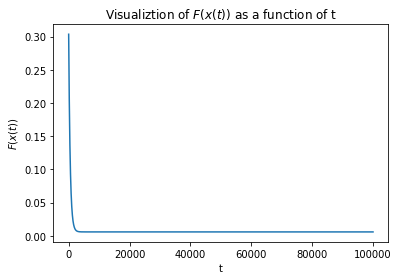

In [21]:
x_t = list_y.clone()
alpha = 0.01
list_t = []
list_f = []
for t in range(int(1e5)):
  f, grad = func(x_t, triples, list_z, list_c)
  list_t.append(t)
  list_f.append(f.detach().numpy().item())
  x_t -= alpha * grad
plt.plot(list_t, list_f)
plt.xlabel("t")
plt.ylabel(r'$F(x(t))$')
plt.title("Visualiztion of " + r'$F(x(t))$' + " as a function of t")
plt.savefig("2.5.1.pdf")

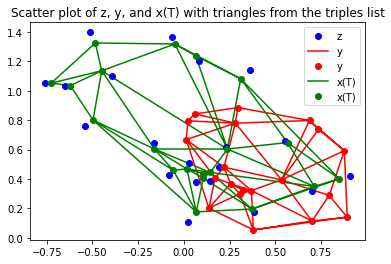

In [22]:
list_triangles = []
for q in range(len(triples)):
  list_triangles.append([triples[q][0], triples[q][1], triples[q][2]])

triang_y = mtri.Triangulation(list_y[:,0], list_y[:,1], triangles=list_triangles)
triang_xt = mtri.Triangulation(x_t[:,0], x_t[:,1], triangles=list_triangles)

plt.plot(list_z[:,0], list_z[:,1], 'o', color = 'blue', label='z')
plt.triplot(triang_y, marker="o", color = 'red', label='y')
plt.triplot(triang_xt, marker="o", color = 'green', label='x(T)')
plt.title("Scatter plot of z, y, and x(T) with triangles from the triples list")
plt.legend()
plt.savefig("2.5.2.pdf")